In [142]:
# import necessary packages
import numpy as np
import copy
import pandas as pd
import missingno
import warnings
import time
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV as gs
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from scipy.special import expit
from scipy.optimize import fmin_bfgs
from scipy.optimize import minimize_scalar

# import dataset
wine = pd.read_csv("winequalityN.csv")

warnings.filterwarnings("ignore")

# Business Use Case

>[2 points] Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results. For example, would the model be deployed or used mostly for offline analysis? 

With the rise in cryptocurrencies and other alternative forms of investment, so comes the rise in wine storage (at least among the wealthy).  As a personal consumer, I have always enjoyed a nice rich red wine from any geographic location.  Preferably a Malbec or Bordeaux.  In fact, I often log which wines I have using the Vino wine app on my iPhone.  The app is amazingly simple and the users provide accurate descriptions on current wines on the market.

However, one feature that Vino lacks is a predictive capability for new to market wines.  For example, when I buy or order a new 2022 wine, I often struggle with user reviews on Vino - because often, newer wines are always labeled as lower quality due to the sheer nature of wine age.  Often, I will see a poorly rated wine that ends up being an underdog for a 90+ rated wine.  Bias in age of wine often plays a major part in inaccurate ratings from users on Vino.

I think that quality can be, and should be, predicted for new to market wines - at least for the first year of a wine.  I think most wine connoisseurs can be honest when it comes to describing wine attributes (citric, acidity, baseness, earthiness, etc.).  Using these features to describe a wine can be used to predict the rough quality of a wine.  Although not a perfect solution, it is a good method of predicting opinions that otherwise might be biased.  This method also allows for new users to feel more at ease with a more "accurate" rating of newer wines.  This model should deployed live and should adjust with each new user entry

---
Notes on the data:

UCI Machine Learning Repository has provided a wine quality dataset that contains data on red and white Portuguese Vinho Verde.  This data contains most important aspects of wine - such as different taste types, density, color, etc.  The output variable is quality (on a scale of 1 - 10).

The dataset from Kaggle is a partially processed dataset (could not find the raw data from Kaggle).  I don't believe that the authors to process this dataset took out import information.

Data source: https://www.kaggle.com/datasets/rajyellow46/wine-quality

## Data Preprocessing

In [143]:
# describe the dataset
wine.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


<AxesSubplot:>

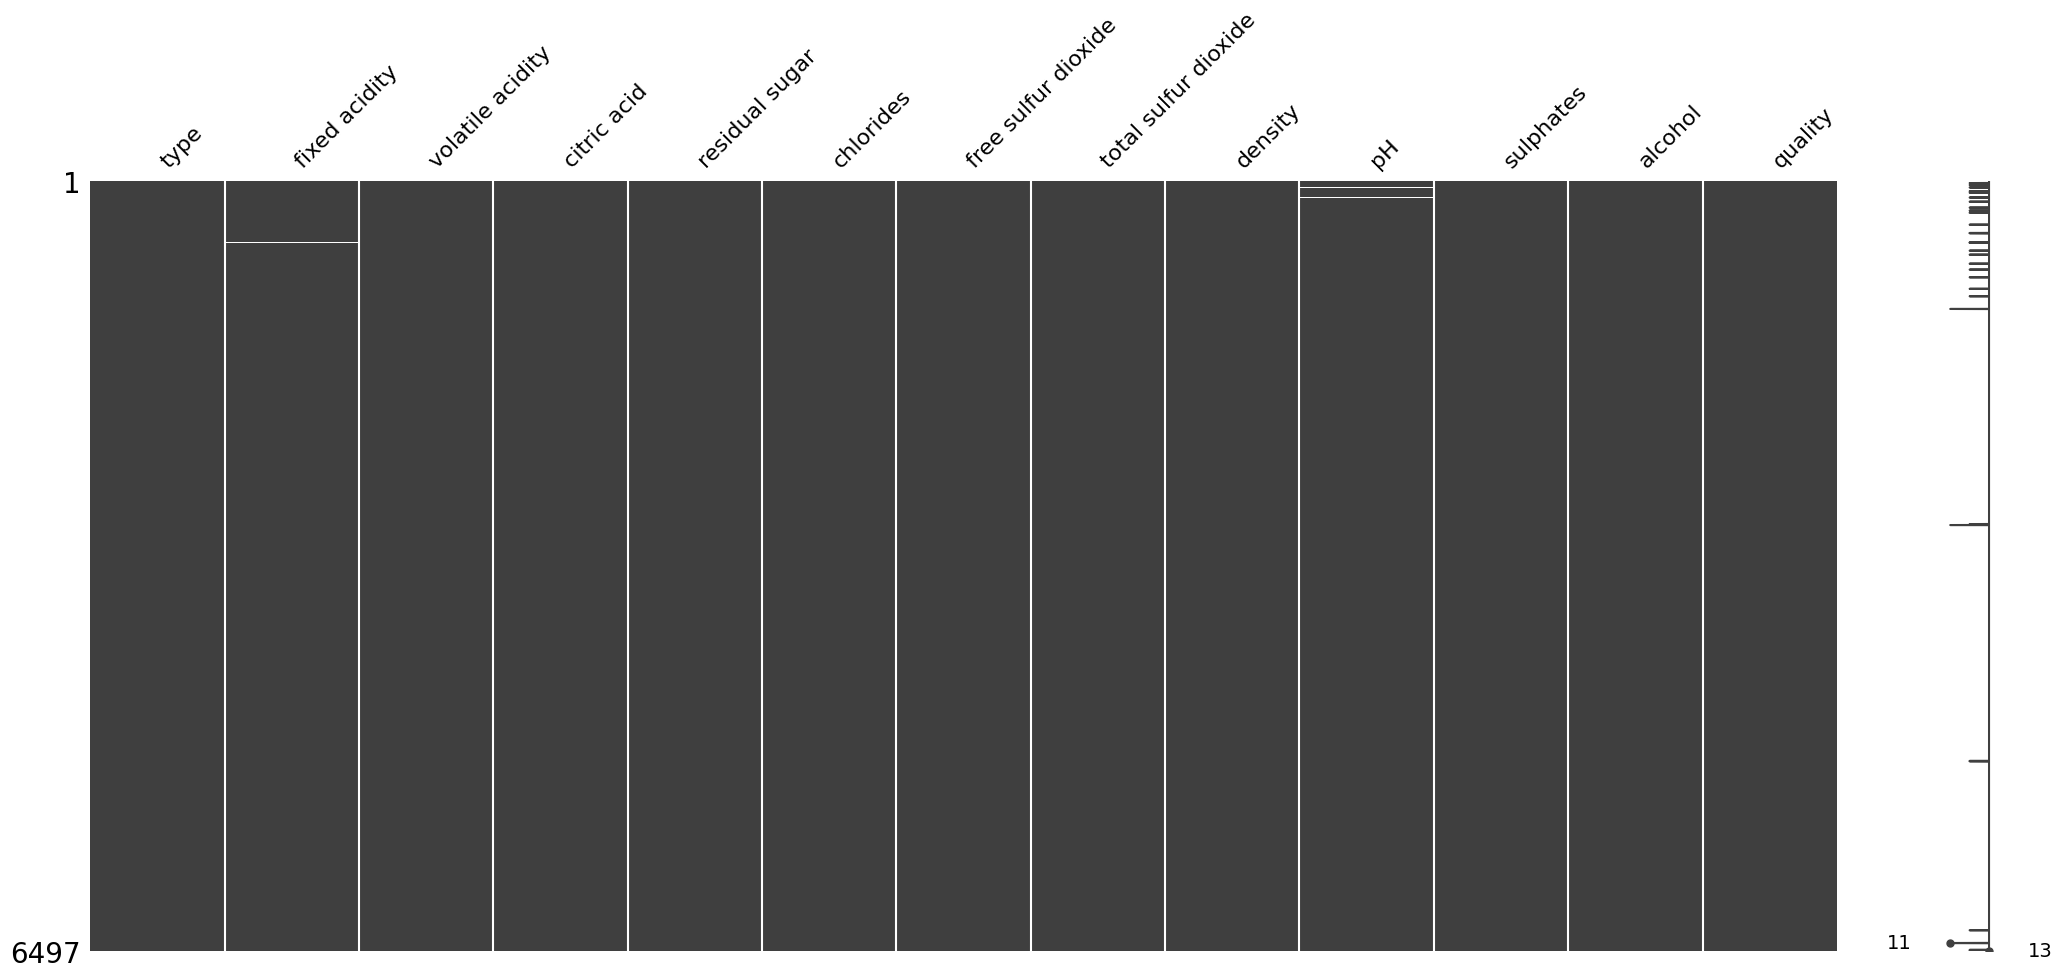

In [144]:
# identify null records
missingno.matrix(wine)

In [145]:
# replace null values with 0
wine = wine.fillna(0)

>[.5 points] (mostly the same processes as from previous labs) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

Based on the summarizations above, it is safe to say that the current dataset is appropriately processed for missing values.  Any additional missing values (which there were only 3) were given a value of 0 as it is assumed that if there is no value for a heavily quantitative dataset, that means that the value would most likely be 0.  This only affected 3 records, so it is safe to assume this should not affect the entirety of the dataset.  In terms of outliers, I am choosing to keep all records within this dataset.

In [146]:
# one-hot encode categorical variables (type)
one_hot = pd.get_dummies(wine["type"], prefix='type')

In [147]:
# join back onto original dataset
wine = wine.join(one_hot)
del wine["type"]

array([[<AxesSubplot:title={'center':'quality'}>]], dtype=object)

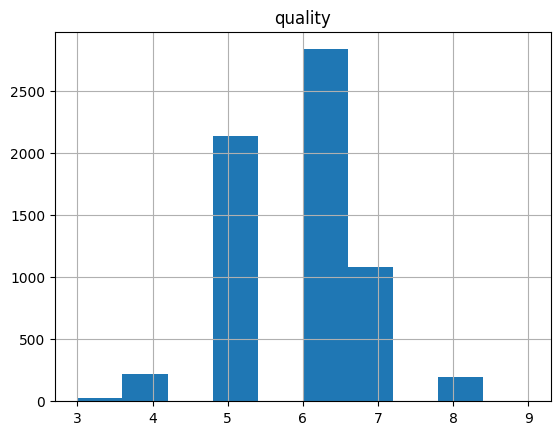

In [148]:
# identify the distributions of output values
wine.hist("quality")

In the above histogram, we see what the distributions of output values are.  This is important and can determine the health of our model: sparse outputs are not very useful.  The outputs above show a normalish distribution centered around 6.  Therefore, we should reduce this dimension to 3 categories:
- 0: Low quality
- 1: Average quality
- 2: High quality

We do this for 2 reasons:
1. This allows us to create output variables that have a healthy amount of data points and are more easily predictable
2. Most importantly: we define what quality is, so when we deploy this model to an app, we can provide our consumers easily digestable categories of what type of wine quality they may be consuming

There is another method - providing an average rating with a distribution range.  For now, good enough is defined by providing the customer a ballpark.  Subjectivity often requires rough estimation and not pinpoint precision anyways.

In [149]:
# recode quality
wine.loc[wine["quality"] == 3, "quality"] = 0
wine.loc[wine["quality"] == 4, "quality"] = 0
wine.loc[wine["quality"] == 5, "quality"] = 0
wine.loc[wine["quality"] == 6, "quality"] = 1
wine.loc[wine["quality"] == 7, "quality"] = 2
wine.loc[wine["quality"] == 8, "quality"] = 2
wine.loc[wine["quality"] == 9, "quality"] = 2

print(len(wine[wine["quality"] == 0]))
print(len(wine[wine["quality"] == 1]))
print(len(wine[wine["quality"] == 2]))

2384
2836
1277


We only need to one hot encode one variable (type) because this is our only categorical variable.  I choose a method of one hot encoding and splitting the columns.  I.e. type_red and type_white are separate columns as opposed to a single column "type".  A 1 in type_red denotes the white is red, likewise with type_white.

In [150]:
# create X dataset
X = wine.copy()
del X["quality"]
X = np.array(X)

# create y dataset
y = wine["quality"]
y = np.array(y)

In [151]:
# scale the dataset
scaler = MinMaxScaler()
scaler = scaler.fit(X)
X = scaler.transform(X)

I chose to use a min max scaler as this is a standard scaler used in most cases.  Other scalers can also work with this dataset.  The data needs to be scaled because of the vast differences in mins and maxes of the data.  Additionally, scaled data allows for better predictive capabilites as all data will be within the same magnitude relative to each other.

## Model Construction

>The implementation of logistic regression must be written only from the examples given to you by the instructor. No credit will be assigned to teams that copy implementations from another source, regardless of if the code is properly cited. 

>[2 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:
1. Ability to choose optimization technique when class is instantiated: either steepest ascent, stochastic gradient ascent, and {Newton's method/Quasi Newton methods}. 
2. Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated. 


In this section, I construct our base class (binary regression) and then branch off and create each specialized calculated class.  The final class is our multiclass logistic regression class - which contains the logic to predict on multiclassifications.  **All classes were taken from the lecture notebooks but modified to inclulde:**
1. Adjustable optimization technique
2. Adjustable regularization term
3. Adjustable cost C

The differences in each class is the gradient calculations.  Each class can be called upon as the "solver".  Each class can be modified with the eta, iterations, and C parameter.

For regularization there are 4 options: none, l1, l2, l1l2.  None will update the gradient with no modification to the summation of the weights: 

$$ l(\mathbf{w})_{reg} = l(\mathbf{w})_{prev} - C\cdot\sum_j w_j $$

l1 regularization updates the weights using the absolute value of the summation of the weights

$$ l(\mathbf{w})_{reg} = l(\mathbf{w})_{prev} - C\cdot\sum_j |w_j| $$

Using the chain rule, and this youtube video to help me: https://www.youtube.com/watch?v=TboqFzkx-a4&t=117s

The updated function is as follows:

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \left[\underbrace{\nabla l(\mathbf{w})_{prev}}_{\text{previous gradient}} - C \cdot \dfrac{\mathbf{w}}{\mathbf{|w|}} \right]$$

l2 regularization updates the weights using the square of the summation of the weights:

$$ l(\mathbf{w})_{reg} = l(\mathbf{w})_{prev} - C\cdot\sum_j w_j^2 $$

Using the chain rule, the udpated function is as follows:

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \left[\underbrace{\nabla l(\mathbf{w})_{prev}}_{\text{previous gradient}} - C \cdot 2\mathbf{w} \right]$$

l1l2 regularization is the multiplication of both (at least that's what I'm doing).  I've never seen l1l2 used jointly as usually - at least in sci-kit learn - l1 and l2 are used for different solvers and some solvers can not use l1 or l2.

The updated function for l1l2 would be as follows:

$$ l(\mathbf{w})_{reg} = l(\mathbf{w})_{prev} - C\cdot\sum_j w_j^2\cdot|w_j| $$

Which simplifies (using the derivative calculator: https://www.derivative-calculator.net

$$ \mathbf{w} \leftarrow \mathbf{w} + \eta \left[\underbrace{\nabla l(\mathbf{w})_{prev}}_{\text{previous gradient}} - C \cdot 3\mathbf{w}|\mathbf{w}| \right]$$

In [183]:
# from last time, our logistic regression algorithm is given by (including everything we previously had):
class BinaryLogisticRegression:
    def __init__(self, eta, iterations=20, C=0.001, regularization_term="none", optimizer="bfgs"):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.regularization_term = regularization_term
        self.optimizer = optimizer
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_)
        else:
            return 'Untrained Binary Logistic Regression Object'
        
    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X))
    
    @staticmethod
    def _sigmoid(theta):
        return expit(theta)
    
    def _objective_function(self,w,X,y,C):
        g = expit(X @ w)
        return -np.sum(np.ma.log(g[y==1]))-np.sum(np.ma.log(1-g[y==0])) + C*sum(w**2)

    def _objective_gradient(self,w,X,y,C):
        g = expit(X @ w)
        ydiff = y-g
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)

        # regularize gradient
        # gradient[1:] += -2 * w[1:] * C
        gradient = self._regularize_gradient(gradient)
        
        return -gradient

    # regularize the gradient using each gradient function
    def _regularize_gradient(self, gradient):

        if self.regularization_term == "none":
            gradient[1:] += -self.w_[1:] * self.C

        if self.regularization_term == "l1":
            gradient[1:] += -self.w_[1:]/np.abs(self.w_) * self.C

        if self.regularization_term == "l2":
            gradient[1:] += -2 * self.w_[1:] * self.C

        if self.regularization_term == "l1l2":
            gradient[1:] += -3 * self.w_[1:] * np.abs(self.w_[1:]) * self.C

        return gradient
    
    def _get_gradient(self,X,y):
        
        if self.optimizer == "batch":
            ydiff = y[:,np.newaxis]-self.predict_proba(X,add_bias=False)
            gradient = np.sum(X * ydiff,axis=0)
            gradient = gradient.reshape(self.w_.shape)

            # regularize gradient
            # gradient[1:] += -2 * self.w_[1:] * self.C
            gradient = self._regularize_gradient(gradient)

            return gradient
        
        if self.optimizer == "sgd":
            idx = int(np.random.rand()*len(y))
            ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False)
            gradient = X[idx] * ydiff[:,np.newaxis]
            gradient = gradient.reshape(self.w_.shape)

            # regularize gradient
            # gradient[1:] += -2 * self.w_[1:] * self.C
            gradient = self._regularize_gradient(gradient)

            return gradient 
        
        if self.optimizer == "newton":
            g = self.predict_proba(X,add_bias=False).ravel()
            hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C

            ydiff = y-g
            gradient = np.sum(X * ydiff[:,np.newaxis], axis=0)
            gradient = gradient.reshape(self.w_.shape)

            # regularize gradient
            # gradient[1:] += -2 * self.w_[1:] * self.C
            gradient = self._regularize_gradient(gradient)

            return np.linalg.pinv(hessian) @ gradient
        
        if self.optimizer == 'mse':

            # this is standard as all other optimizers
            g = self.predict_proba(X, add_bias=False).ravel()
            
            # calculated hessian using the lecture notebook
            hessian = X.T @ np.diag(-2/len(X) * g**2 * (1-g) * ((g-1) + (g**2 - y*g))) @ X - 2 * self.C
            
            # gradient calculation - same as newton method
            gradient = np.sum(X * ((-2 * (y-g) * (-g * (1-g)) )[:,np.newaxis]), axis=0)
            gradient = gradient.reshape(self.w_.shape)
            gradient[1:] += -2 * self.w_[1:] * self.C
            
            # regularize gradient
            gradient = self._regularize_gradient(gradient)

            return np.linalg.pinv(hessian) @ gradient
    
    # public:
    def predict_proba(self,X,add_bias=True):
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_)
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5)
    
    def fit(self, X, y):
        if self.optimizer == "bfgs":
            Xb = self._add_bias(X)
            num_samples, num_features = Xb.shape
            
            self.w_ = np.zeros(num_features)

            self.w_ = fmin_bfgs(self._objective_function,
                                np.zeros((num_features,1)),
                                fprime=self._objective_gradient,
                                args=(Xb,y,self.C),
                                gtol=1e-03,
                                maxiter=self.iters,
                                disp=False)

            self.w_ = self.w_.reshape((num_features,1))
            
        else:
            Xb = self._add_bias(X)
            num_samples, num_features = Xb.shape

            self.w_ = np.zeros((num_features,1))

            # for as many as the max iterations
            for _ in range(self.iters):
                gradient = self._get_gradient(Xb,y)
                self.w_ += gradient*self.eta

### 1 vs all classifier

The following class will be my main classifier that a typical user will interface with.  This will be the **a mostly equivalent version of Sci-Kit Learn's LogisticRegression**.  The idea of this class is to bring all different regression types together into a single interactive class.  This class will be used to perform fits and predicts later on in the analysis

In [184]:
# allow for the user to specify the algorithm they want to solver the binary case
class MultiClassLogisticRegression:
    def __init__(self, eta=1, iterations=20, C=0.01, optimizer="sgd"):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.optimizer = optimizer
        self.classifiers_ = []
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []


        for i,yval in enumerate(self.unique_):
            y_binary = np.array(y==yval).astype(int)

            # set optimizer based on options
            opt = BinaryLogisticRegression(eta=self.eta,iterations=self.iters,C=self.C,optimizer=self.optimizer)
            opt.fit(X,y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(opt)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1)))
        
        return np.hstack(probs)
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1)

>[.5 points] Divide your data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?

This next function define will be my train/test split function.  The test size will be set to 20% for two reasons:
1. 20% is industry standard for the majority of datasets.  The pareto rule was the inspiration for this split
2. This particular dataset has enough records (instances) of data to justify a larger split.  Sometimes, in practice, I've seen smaller splits for smaller datasets (i.e. 10% test size for 1000-2000 instances).

In [178]:
def train_test_split(num_cvs, test_size):
    num_instances = len(y)
    cv_object = ShuffleSplit(n_splits=num_cvs, test_size=test_size)
    
    return cv_object

### Assess and pick best model

>[1.5 points] Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term(s) "C" to achieve the best performance on your test set. 

The following section uses a "grid search" method - although crudely implemented.  The idea is to search for the model with the highest score term (accuracy for this example). 

>Visualize the performance of the classifier versus the parameters you investigated. Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?

I think it's fair to say that *some* level of data snooping is involved.  Afterall, I am literally scanning values and picking the best option.  But I can make a case for no data snooping as I'm not scanning for the most optimal values - C and eta are only being scanned on the 1 scale.  There are other values like 0.0002 or 0.05 that may be better values.  So, yes limited data snooping is involved - but not terrible data snooping where I'm making an algorithm to get the most optimal parameters to fit my dataset.  **Nor am I modifying my dataset to a degree where I get a desirable output.**  I think my previous explanation of condensing output variables to 3 categories was logically justified.  That would take too long and most likely would not be worth the resources for this exercise.

Overall, I still think my method of searching for desirable parameters is justified.

This method would not be implemented in a deployed version of this model but would be used to update the model every so often

In [18]:
# brute force each parameter for "optimal" model
eta = [0.001, 0.01, 0.1, 1]
C = [0.0001, 0.001, 0.01, 0.1, 1]
regularization_terms = ["none", "l1", "l2", "l1l2"]

def grid_search(opt, regularization_terms, C, eta):
    
    # define mostly static parameters
    iterations = 50
    num_cvs = 3
    test_size = 0.2
    best_accuracy = 0
    best_model = ""

    # initialize empty lists to store model information
    accs = []
    model_parameters = []
    times = []

    # iterate through each parameter
    for regularization_term in regularization_terms:
        for c in C:
            for e in eta:

                # initialize model
                lr = MultiClassLogisticRegression(eta=e, iterations=iterations, C=c, optimizer=opt)

                # split the train and test data
                cv_object = train_test_split(num_cvs=num_cvs, test_size=test_size)

                # initialize empty lists of accuracies and times
                acc = []
                split_times = []

                # iterate through dataset
                for train_idx, test_idx in cv_object.split(X, y):

                    # split train and test datasets
                    X_train = X[train_idx]
                    X_test = X[test_idx]
                    y_train = y[train_idx]
                    y_test = y[test_idx]

                    # start time
                    start_t = time.time()

                    # fit model and predict
                    lr.fit(X_train,y_train)
                    yhat = lr.predict(X_test)

                    # end time
                    end_t = time.time()

                    # calculate accuracies
                    accuracy = accuracy_score(y_test, yhat)

                    # store accuracies
                    acc.append(accuracy)

                    # store time per accuracy calculation
                    split_times.append(end_t - start_t)

                    # compare accuracies to determine highest accuracy
                    if accuracy > best_accuracy:

                        # extract best parameter information
                        best_accuracy = accuracy
                        best_model = lr
                        best_model_type = lr.optimizer

                # log the model parameters as a string
                model_str = opt + "," + regularization_term + "," + str(c) + "," + str(e)

                # store model infromation, accuracy information, and times per model
                model_parameters.append(model_str)
                accs.append(acc)
                times.append(np.mean(split_times))

    print("best acc: ", best_accuracy)
    print("best model: ", best_model_type)
    return accs, model_parameters, times

# calculate all accuracies and parameters per model
batch_accs, batch_model_parameters, batch_times = grid_search(opt="batch", regularization_terms=regularization_terms, eta=eta, C=C)
sgd_accs, sgd_model_parameters, sgd_times = grid_search(opt="sgd", regularization_terms=regularization_terms, eta=eta, C=C)
bfgs_accs, bfgs_model_parameters, bfgs_times = grid_search(opt="bfgs", regularization_terms=regularization_terms, eta=eta, C=C)
newton_accs, newton_model_parameters, newton_times = grid_search(opt="newton", regularization_terms=regularization_terms, eta=eta, C=C)

# highest accuracies per optimizer
batch_max_idx = batch_accs.index(max(batch_accs))
batch_best_model = batch_model_parameters[batch_max_idx]

sgd_max_idx = sgd_accs.index(max(sgd_accs))
sgd_best_model = sgd_model_parameters[sgd_max_idx]

bfgs_max_idx = bfgs_accs.index(max(bfgs_accs))
bfgs_best_model = bfgs_model_parameters[bfgs_max_idx]

newton_max_idx = newton_accs.index(max(newton_accs))
newton_best_model = newton_model_parameters[newton_max_idx]

# get times for best accuracies
batch_time = batch_times[batch_max_idx]
sgd_time = sgd_times[sgd_max_idx]
bfgs_time = bfgs_times[bfgs_max_idx]
newton_time = newton_times[newton_max_idx]

best acc:  0.563076923076923
best model:  batch
best acc:  0.5030769230769231
best model:  sgd
best acc:  0.6153846153846154
best model:  bfgs
best acc:  0.6215384615384615
best model:  newton


In [155]:
# extract model parameters
batch_optimizer = batch_best_model.split(",")[0]
batch_regularization_term = batch_best_model.split(",")[1]
batch_C = float(batch_best_model.split(",")[2])
batch_eta = float(batch_best_model.split(",")[3])

sgd_optimizer = sgd_best_model.split(",")[0]
sgd_regularization_term = sgd_best_model.split(",")[1]
sgd_C = float(sgd_best_model.split(",")[2])
sgd_eta = float(sgd_best_model.split(",")[3])

bfgs_optimizer = bfgs_best_model.split(",")[0]
bfgs_regularization_term = bfgs_best_model.split(",")[1]
bfgs_C = float(bfgs_best_model.split(",")[2])
bfgs_eta = float(bfgs_best_model.split(",")[3])

newton_optimizer = newton_best_model.split(",")[0]
newton_regularization_term = newton_best_model.split(",")[1]
newton_C = float(newton_best_model.split(",")[2])
newton_eta = float(newton_best_model.split(",")[3])

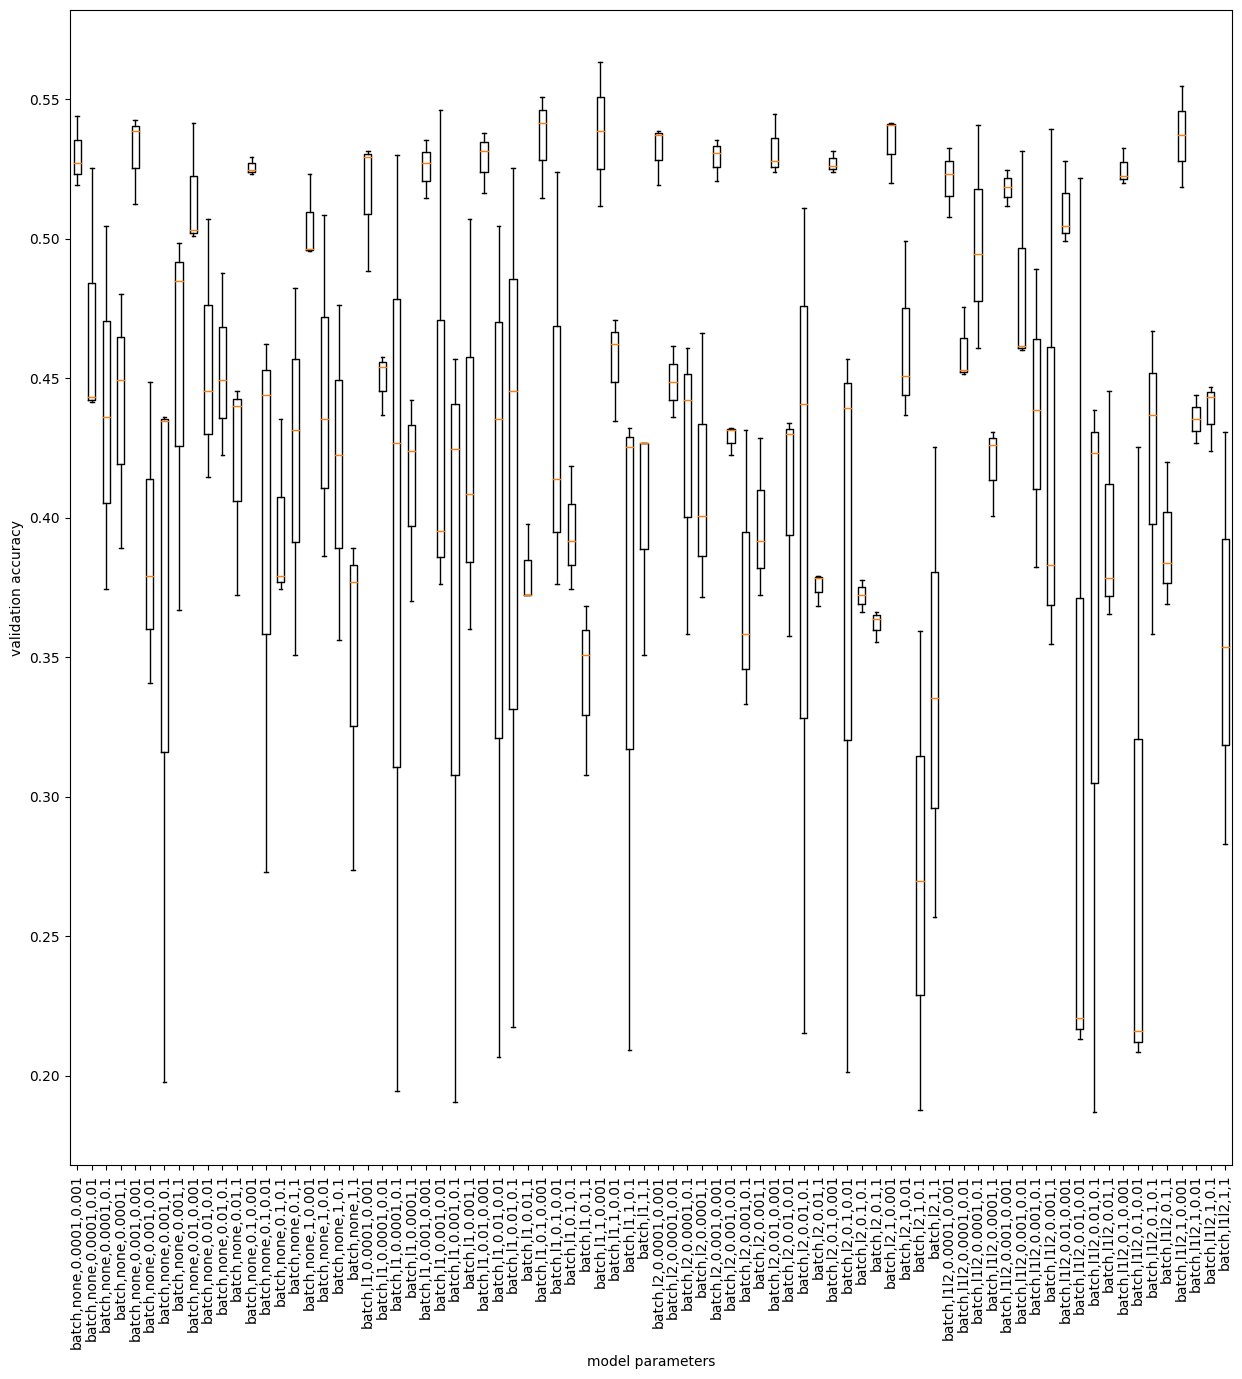

In [156]:
# now show a boxplot of the data across c
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,15))

plt.boxplot(batch_accs)
plt.xticks(range(1,len(batch_model_parameters)+1),[model for model in batch_model_parameters],rotation='vertical')
plt.xlabel('model parameters')
plt.ylabel('validation accuracy')
plt.show()

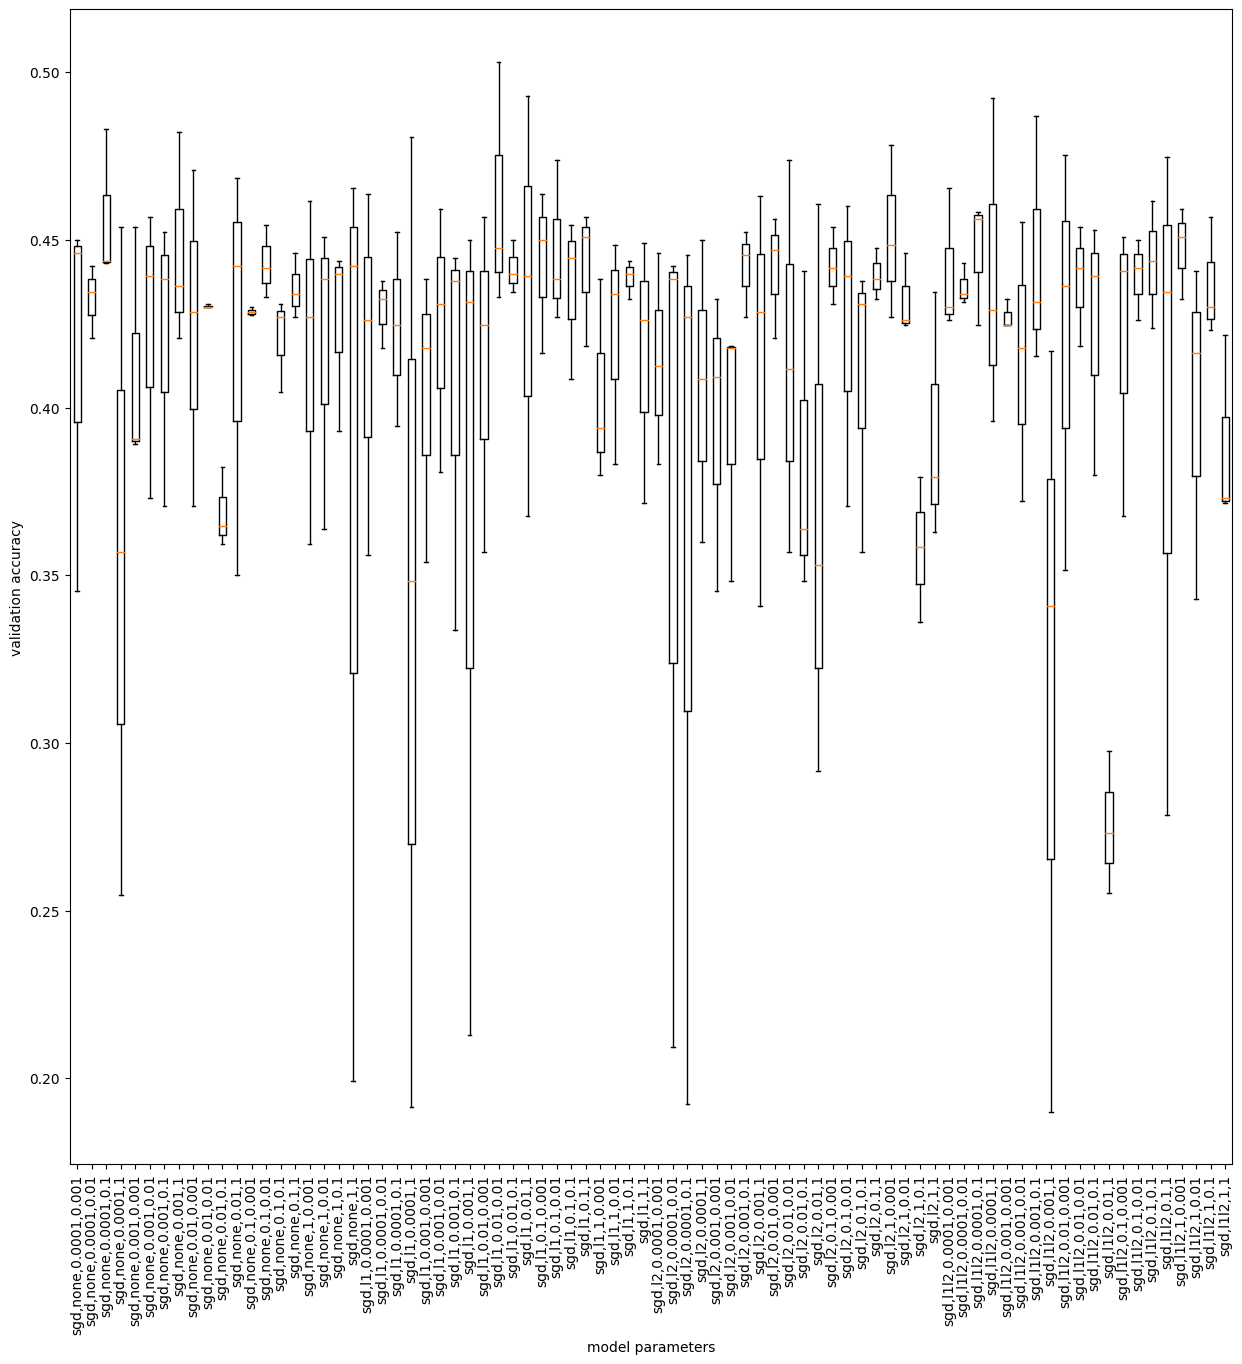

In [157]:
# now show a boxplot of the data across c
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,15))

plt.boxplot(sgd_accs)
plt.xticks(range(1,len(sgd_model_parameters)+1),[model for model in sgd_model_parameters],rotation='vertical')
plt.xlabel('model parameters')
plt.ylabel('validation accuracy')
plt.show()

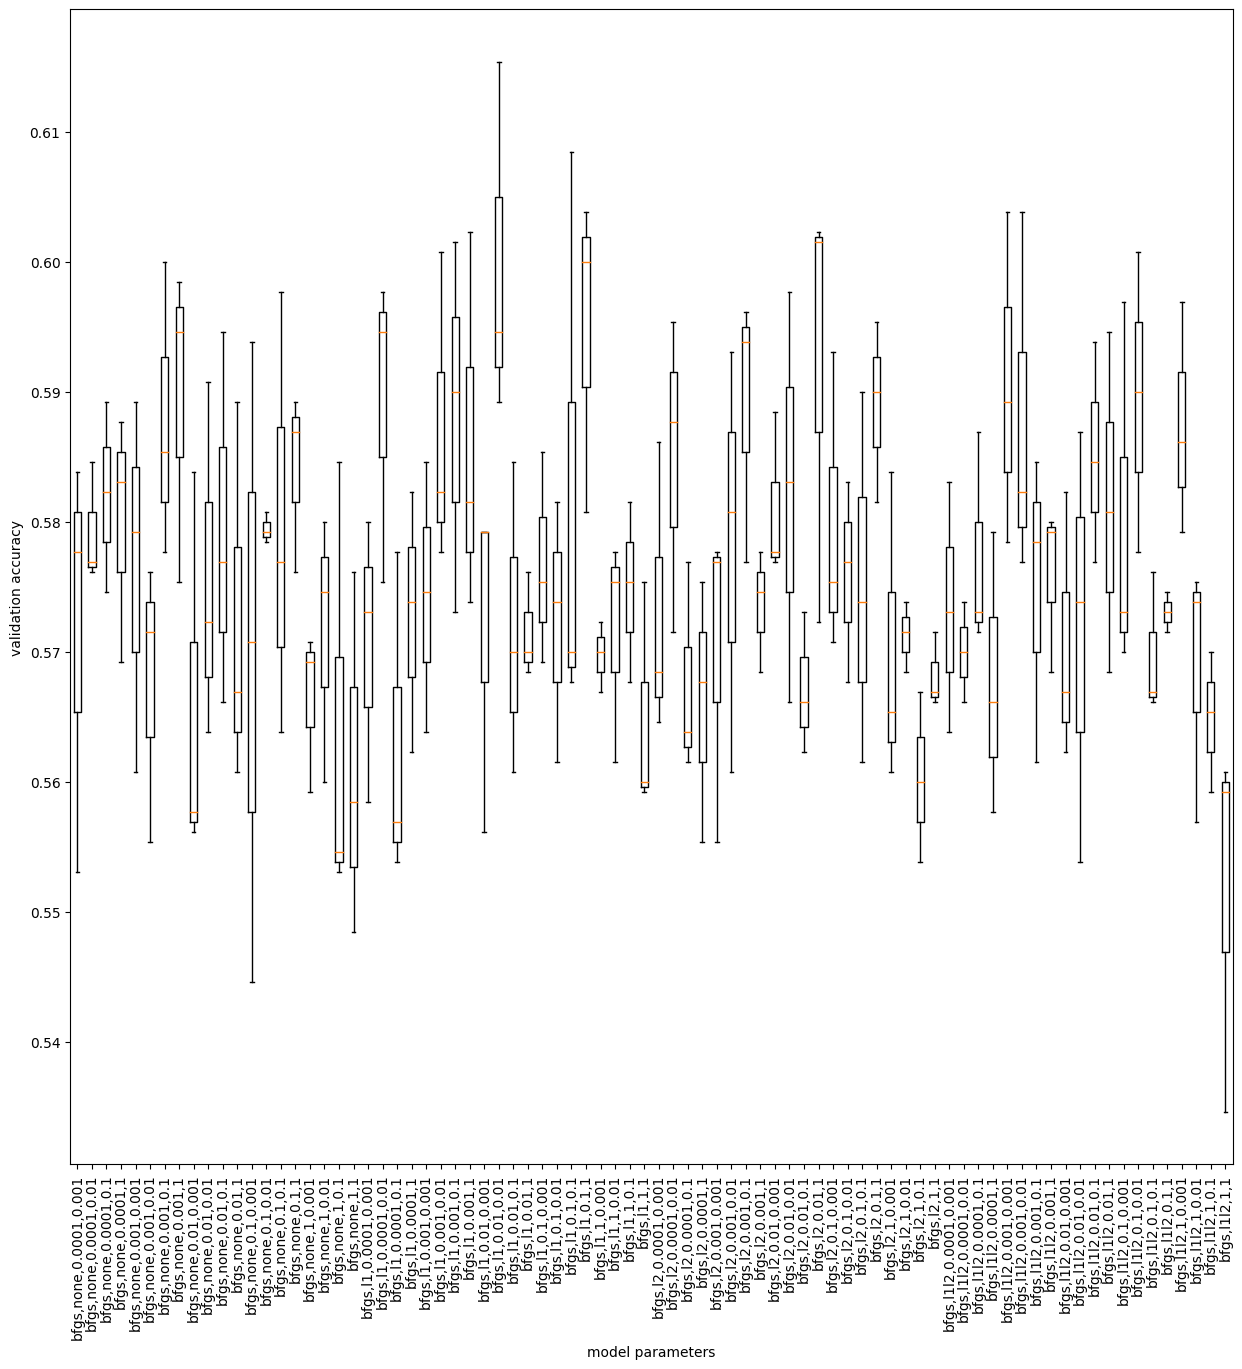

In [158]:
# now show a boxplot of the data across c
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,15))

plt.boxplot(bfgs_accs)
plt.xticks(range(1,len(bfgs_model_parameters)+1),[model for model in bfgs_model_parameters],rotation='vertical')
plt.xlabel('model parameters')
plt.ylabel('validation accuracy')
plt.show()

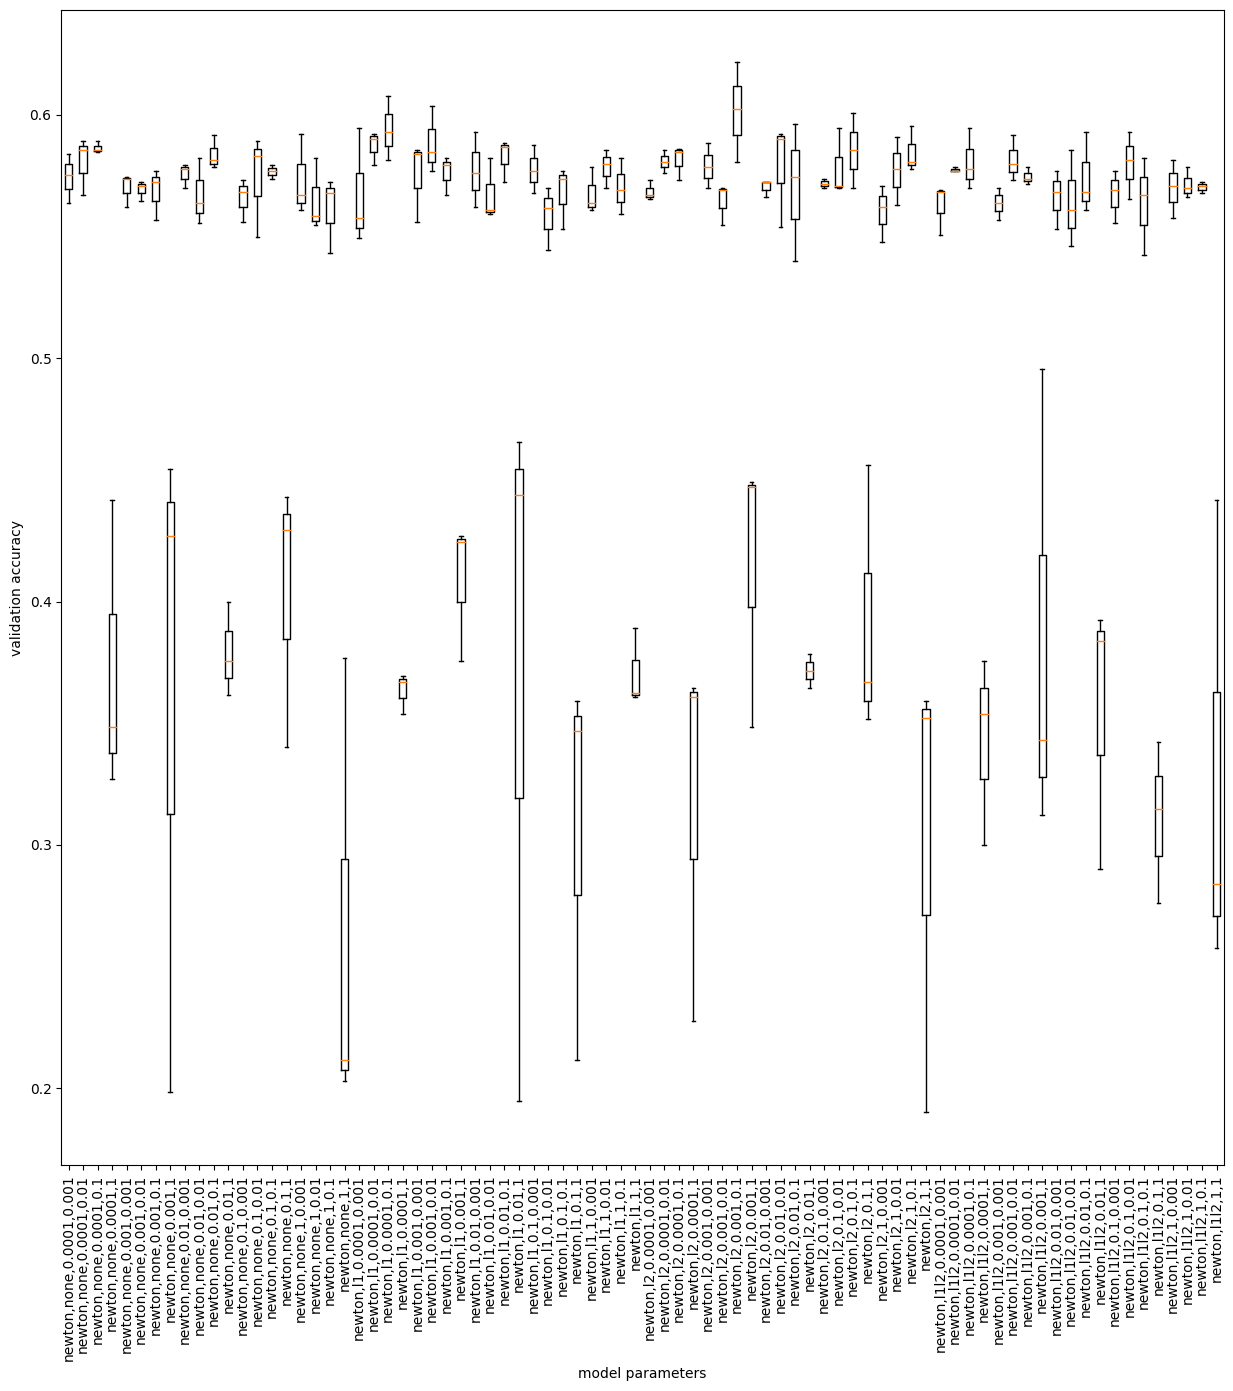

In [159]:
# now show a boxplot of the data across c
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,15))

plt.boxplot(newton_accs)
plt.xticks(range(1,len(newton_model_parameters)+1),[model for model in newton_model_parameters],rotation='vertical')
plt.xlabel('model parameters')
plt.ylabel('validation accuracy')
plt.show()

There are a lot of different variations upon our model.  I chose to stick with the highest score we can achieve - although an argument is to be made that using the highest average score would be more preferable.  Regardless, the accuracies per iteration of the model seem to be roughly steady.  There are no sudden drops.  This means that accuracies will only get better incrementally as opposed to drastically.  I still think a 60% model can be workable and deployable - especially if we reframe our output to be a "most likely" output.  I.e. we design the model to tell a user "This wine is most likely to be of 'X' quality, but has a % chance of being 'Y' quality".  This is still useful - think of these scenarios:
- 60% likely to be average, 20% likely to be high quality: most likely an above average wine
- 60% likely to be average, 20% likely to be low quality: most likely a below average wine
- 60% likely to be low quality, 20% likely to be average: most likely a below average wine
- 60% likely to be low quality, 20% likely to be high quality: a wild card pick, most likely a wine with exotic or risky ingredients/processes
- etc.

No matter what type of combination the model may predict, there is a reasonable, practical, and real-world justification for each.

### Comparison to Sci Kit Learn

>[1.5 points] Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results. 

In [160]:
# optimize for the best solver in SKLearn
lr_sk = LogisticRegression()
param_grid = {
    "solver": ["newton-cg", "libliner", "lbfgs"],
    "penalty": ["l1", "l2", "None"],
    "C": [0.0001, 0.001, 0.01, 0.1, 1]
    }

optimized_lr_sk = gs(lr_sk, param_grid, scoring="accuracy")

sk_accs = []

cv_object = train_test_split(num_cvs=3, test_size=0.2)
for train_idx, test_idx in cv_object.split(X, y):
    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]


    optimized_lr_sk.fit(X_train,y_train)
    yhat = optimized_lr_sk.predict(X_test)
    accuracy = accuracy_score(y_test, yhat)

    sk_accs.append(accuracy)

In the above, we optimize sci-kit learn from the various parameters.  I fed sci-kit learn similar parameters to my model as to keep it apples-to-apples.  The point is to see what parameters are the best for this data using sci-kit learn

In [161]:
# accuracies from each run using sci kit learn
print("sci-kit learn accuracies for best model: ", sk_accs)

# best parameters from sci kit learn
print("sci-kit learn best parameters: ", optimized_lr_sk.best_params_)
sk_c = optimized_lr_sk.best_params_["C"]
sk_penalty = optimized_lr_sk.best_params_["penalty"]
sk_solver = optimized_lr_sk.best_params_["solver"]

sci-kit learn accuracies for best model:  [0.5823076923076923, 0.5938461538461538, 0.5692307692307692]
sci-kit learn best parameters:  {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}


Accuracies are about what my framework is showing as well.  Parameters are wildly different.  Now that we have optimal parameters, let's time it so we have apples-to-apples comparison on performance for time

In [162]:
# for the best solver, time it
lr_sk = LogisticRegression(C=sk_c, penalty=sk_penalty, solver=sk_solver)

sk_accs = []
sk_time = []

cv_object = train_test_split(num_cvs=3, test_size=0.2)
for train_idx, test_idx in cv_object.split(X, y):
    X_train = X[train_idx]
    X_test = X[test_idx]
    y_train = y[train_idx]
    y_test = y[test_idx]


    start_t = time.time()
    lr_sk.fit(X_train,y_train)
    yhat = lr_sk.predict(X_test)
    end_t = time.time()
    accuracy = accuracy_score(y_test, yhat)

    sk_accs.append(accuracy)
    sk_time.append(end_t - start_t)

In [163]:
# accuracies from each run using sci kit learn
print("sci-kit learn accuracies for best model: ", sk_accs)
print("sci-kit learn times for best model: ", sk_time)

sci-kit learn accuracies for best model:  [0.5961538461538461, 0.5876923076923077, 0.5653846153846154]
sci-kit learn times for best model:  [0.06871175765991211, 0.07767939567565918, 0.07248902320861816]


Extremely fast model.  Let's see how this compares to a comprable model from my framework

In [164]:
# comparable accuracies for the same parameters using our model
print("The following accuracies are 'comparable' to sci-kit learn")
print(max(newton_accs[newton_model_parameters.index('newton,l2,1,0.001')]))
print(max(newton_accs[newton_model_parameters.index('newton,l2,1,0.01')]))
print(max(newton_accs[newton_model_parameters.index('newton,l2,1,0.1')]))
print(max(newton_accs[newton_model_parameters.index('newton,l2,1,1')]))

The following accuracies are 'comparable' to sci-kit learn
0.5707692307692308
0.5907692307692308
0.5953846153846154
0.35923076923076924


My newton method has roughly the same accuracies - albeit a little higher for some of the parameters.  To give definition on my parameter string ('newton,l2,1,0.001'):
- first is the optimizer
- second is the regularization term
- third is C
- fourth is eta

In [165]:
# get the average accuracies of each optimizer
def get_averages(l):
    l_avg = []
    for row in l:
        average = sum(row) / len(row)
        l_avg.append(average)
        
    return l_avg

# get the average accuracies for each optimizer
batch_avg_accs = get_averages(batch_accs)
sgd_avg_accs = get_averages(sgd_accs)
bfgs_avg_accs = get_averages(bfgs_accs)
newton_avg_accs = get_averages(newton_accs)
sklearn_avg_accs = sum(sk_accs) / len(sk_accs)
sklearn_avg_time = sum(sk_time) / len(sk_time)

# get the efficiency for each optimizer
batch_efficiency = [acc / time for acc, time in zip(batch_avg_accs, batch_times)]
sgd_efficiency = [acc / time for acc, time in zip(sgd_avg_accs, sgd_times)]
bfgs_efficiency = [acc / time for acc, time in zip(bfgs_avg_accs, bfgs_times)]
newton_efficiency = [acc / time for acc, time in zip(newton_avg_accs, newton_times)]

In the above, we get the average accuracies for each optimizer because we are going to compare accuracies across models and with sci-kit learn.  Additionally, we also want to calculate efficiency.

**This is important: Efficiency is defined as accuracy / time.  Conceptually it tells us how many points of accuracy a model can calculate each second.**

In [166]:
# create a dataframe with each solver x time x avg accuracy
num_repetitions=len(bfgs_accs)

batch_df = pd.DataFrame({
    "classifier": ["batch"] * num_repetitions,
    "time": batch_times,
    "avg_accuracy": batch_avg_accs,
    "efficiency": batch_efficiency
})

sgd_df = pd.DataFrame({
    "classifier": ["sgd"] * num_repetitions,
    "time": sgd_times,
    "avg_accuracy": sgd_avg_accs,
    "efficiency": sgd_efficiency
})

bfgs_df = pd.DataFrame({
    "classifier": ["bfgs"] * num_repetitions,
    "time": bfgs_times,
    "avg_accuracy": bfgs_avg_accs,
    "efficiency": bfgs_efficiency
})

newton_df = pd.DataFrame({
    "classifier": ["newton"] * num_repetitions,
    "time": newton_times,
    "avg_accuracy": newton_avg_accs,
    "efficiency": newton_efficiency
})

sk_learn_df = pd.DataFrame({
    "classifier": ["sklearn"] * num_repetitions,
    "time": [sklearn_avg_time] * num_repetitions,
    "avg_accuracy": [sklearn_avg_accs] * num_repetitions,
    "efficiency": [sklearn_avg_accs / sklearn_avg_time] * num_repetitions
})

optimizer_df = pd.concat([batch_df, sgd_df, bfgs_df, newton_df, sk_learn_df])

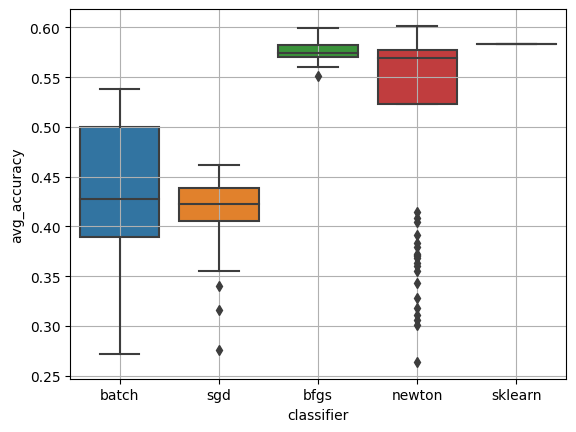

In [167]:
# plot the variations for each optimizer
sns.boxplot(data=optimizer_df, x="classifier", y="avg_accuracy")
plt.grid()

There are clear cut winners and clear cut losers.  Batch and SGD were expected to not perform as high.  BFGS and Newton are most comparable to sklearn (which makes sense as sklearn thinks newton is best).

As of right now, averages are too close to say which method or framework is more desirable for our use case.  Let's look at times

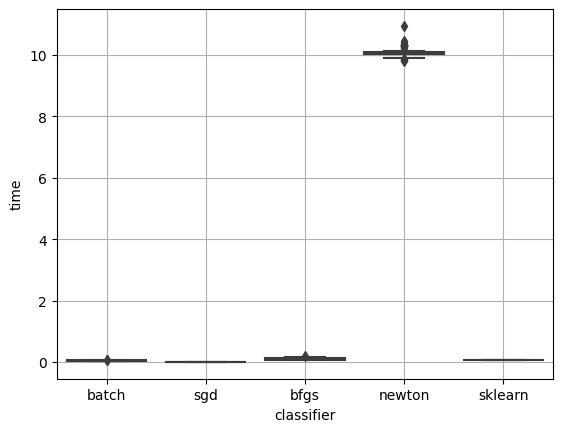

In [168]:
# plot the variations for each optimizer
sns.boxplot(data=optimizer_df, x="classifier", y="time")
plt.grid()

This isn't very useful.  Let's look at efficiency, which is a rate of time and would be much more representative of model performance

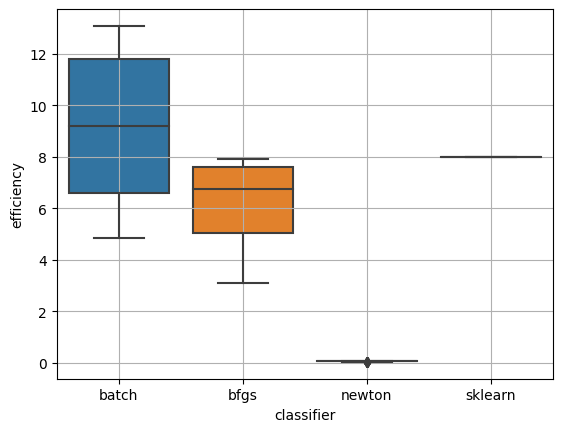

In [169]:
# plot the variations for each optimizer
sns.boxplot(data=optimizer_df[optimizer_df["classifier"] != "sgd"], x="classifier", y="efficiency")
plt.grid()

We can see that sklearn is faster than my fastest implementation (which was also my worst performing implementation).  Sklearn's newton method is 10x faster than my newton method - most likely due to extreme optimization calculating the gradient.  Compared to BFGS (my best model), sklearn is about 33% faster.  Although my model was ultimately more accurate, sklearn had a faster implementation.  

But ultimately, what can we deduce from these results and how this relates to our business case?  We have, let's call, 60% accuracy using the current framework or sci-kit learn's.  We care about accuracy because we want to accurately give a good quality rating to newer wines for customers.  However, we can expand our results by including the 2nd rank in our results (as discussed above in a previous section).  Including this 2nd rank, we can derive new ranks (also as discussed above) that would be valuable to helping consumers pick and choose new wines that pique their palettes.

I'm unsure if sci-kit learn supports capturing probabilities when predicting per instance.  But I do know it would be possible to add it a way to capture the second most likely output per instance when iterating over each instance.  I know neural networks hold this capabilities for softmax outputs.

## Deployment

>Deployment (1 points total)
Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?

Between Scikit-learn and my implementation, I would recommend Sci-kit although my framework and model are very close to beating it.  My best performing model (bfgs) beats sci-kit learns best performing model by a few % points on average.  However, bfgs takes slightly longer time and its efficiency is significantly lower that sci-kit learn's.  If we were to really optimize sci-kit learn vs my implementation and do extensive grid searching, sci-kit learn would be mostly equal in terms of % but would be far more efficient as it's already an optimized model.

But, in terms of deployment, there is a case to be made that my model is more attractive to deploy: lack of speed is not important.  Speed, although important for live models, is not high priority for a wine app for a few reasons:
- There are not that many new wines produced daily
- We aren't using my Newton method (very slow) for my implementation of a model because it gets outperformed
- Therefore, model fits on new data would be fast enough to not hinder UX.

**However**, I would ultimately decide on a Neural Network approach for quicker results, easier time deriving probablistic outputs, and much more accurate (usually).

But for this exercise, I believe sci-kit learn is the safer option - but it has a competitor.

## Mean Squared Error

> Implement an optimization technique for logistic regression using mean square error as your objective function (instead of maximum likelihood). Derive the gradient updates for the Hessian and use Newton's method to update the values of "w". Then answer, which process do you prefer: maximum likelihood OR minimum mean-squared error? 

I used this as reference to calculate the derivative of MSE: https://sebastianraschka.com/faq/docs/mse-derivative.html

And I used this as how I went about this specific problem: https://math.stackexchange.com/questions/3961889/is-my-partial-derivation-of-mse-loss-function-correct-w-r-t-to-w1

You may have noticed reading my source code for logistic regression that there is a 5th optimizer: MSE.  I did not showcase mse until now.  Originally, our objective function is as follows:

$$ l(\mathbf{w}) = \frac{1}{M}\cdot\sum_i \left( y^{(i)} \ln [g(\mathbf{w}^T \mathbf{x}^{(i)})] + (1-y^{(i)}) (\ln [1 - g(\mathbf{w}^T \mathbf{x}^{(i)})])  \right)  $$

However, using Mean-Squared Error, we have a new function to optimize: 

$$l(w) = \frac{1}{N}\sum_{n=0}^N \left(y^{(i)} - g \right)^2 $$ 

Where our function used to predict is:

$$ g = \frac{1}{1 - exp(w^Tx^{(i)})}$$

So taking the derivative with respect to $w$ and using a little bit of google because I'm not very good at derivatives, we come at:

$$\nabla l(w)_j = \frac{2}{N} \sum_{i=0}^N \left(y^{(i)} - g\right)x^{(i)}_j $$ 


To calculate the hessian, we take the second derivative with respect to $w$.  **And remember, the derivative of a sigmoid is itself times 1 minus itself**.  Using the lecture Jupyter Notebook 06.Optimization:

$$\nabla^2 l(w)_{jk} = \frac{-2}{N} \sum_{i=0}^n \left( g^2(1-g)((g-1) + (g^2 - yg) \right) x^{(i)}_j x^{(i)}_k $$

In [185]:
# assess MSE
eta = [0.001, 0.01, 0.1, 1]
C = [0.0001, 0.001, 0.01, 0.1, 1]
regularization_terms = ["none", "l1", "l2", "l1l2"]

mse_accs, mse_model_parameters, mse_times = grid_search(opt="mse", regularization_terms=regularization_terms, eta=eta, C=C)

# highest accuracies
mse_max_idx = mse_accs.index(max(mse_accs))
mse_best_model = mse_model_parameters[mse_max_idx]

# get times for best accuracies
mse_time = mse_times[mse_max_idx]

best acc:  0.5684615384615385
best model:  mse


In [186]:
print("The best model accuracy for MSE: ", max(mse_accs))
print("The best model parameters for MSE: ", mse_best_model)
print("The best model time for MSE: ", mse_time)

The best model parameters for MSE:  mse,none,0.01,0.001
The best model time for MSE:  10.138533035914103


It appears that MSE is running at roughly the same speeds as my newton method (very slow).  But the accuracies haven't really changed and may be even worse.  Although MSE was a good exercise to look at, it really wasn't worth the time.  I prefer the maximum likelihood over MSE because it is a much simpler calculation and I'm not 100% certain I even calculated MSE correctly for my derivatives.  But seriously, maximum likelihood, for this use case, would fair better because of time.  The accuracy from MSE follows the expression: the juice ain't worth the squeeze.

In the end, sci-kit learn is the clear winner out of everything - but that's to be expected.